### Denoising Signal

Dans ce notebook, je présente deux méthodes pour débruiter un signal.

J'utilise un autoencodeur, puis un ACP.


In [1]:
import os
import torch
torch.manual_seed(42)
import numpy as np

import torchvision.datasets as dst
import torchvision

from torch.utils.data import DataLoader

import torch.nn as nn

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()




In [2]:
#Convert image to tensor
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [3]:
#Télécharger les données

MNIST=dst.MNIST(root='./data',download=True, transform=transform)

In [4]:
#Charger les données
data_load=DataLoader(MNIST,batch_size=128,num_workers=4)

In [177]:
def imshow(image):
    '''Cette fonction convertit un tensor en image et le montre
    inputs:
    _________________________
    
    image: tensor object
    
    
    returns:
    _______________________________
    
    plot of the images
    
    '''
    np_image=np.transpose(image.numpy(),(1,2,0))
    
    np_image=np.clip(np_image,0,1)
    plt.imshow(np_image)
    

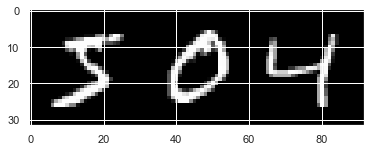

In [36]:
data_iter=iter(data_load)
img,_=next(data_iter)

imshow(torchvision.utils.make_grid(img[:3]))


In [7]:
def add_noise(img):
    '''
    inputs: image
    _________________________
    
    return: noising image
    
    '''
    
    noise=torch.randn_like(img)*0.2
    return img+noise

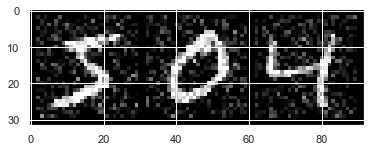

In [8]:
images=add_noise(img)

imshow(torchvision.utils.make_grid(images[:3]))

In [9]:
img.view(img.size(0),-1).size()

torch.Size([128, 784])

In [42]:
img.size()

torch.Size([128, 1, 28, 28])

In [25]:
class Ae(nn.Module):
    def __init__(self):
        
        '''
        Une classe autoencodeur, on lui passe le signal, il 
        
        
        
        
        
        '''
        
        
        
        
        
        
        super (Ae,self).__init__()
        self.encoder=nn.Sequential(
                            nn.Linear(in_features=28*28,out_features=256),
                            nn.ReLU(True),
                            nn.Linear(in_features=256,out_features=64),
                            nn.ReLU(True)
                                )
            
        self.decoder=nn.Sequential(
                        nn.Linear(in_features=64,out_features=256),
                        nn.ReLU(True),
                        nn.Linear(in_features=256,out_features=28*28),
                        nn.Sigmoid())
            
            
            
            
    def forward(self,x):
            x=self.encoder(x)
            x=self.decoder(x)
            return x
            
            

In [43]:
def to_image(img):
    return img.view(img.size(0),1,28,28)

In [49]:
lr=0.01
epochs=100

model=Ae()
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


for epoch in range(epochs):
    for i, data in enumerate(data_load):
        img,_=data
        img=img.view(img.size(0),-1)
        
        noise_img=add_noise(img)
        output=model(noise_img)
        
        loss=criterion(output,img)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
        
    if epoch % 10 == 0:
        print(f'epoch[{epoch+1}/{epochs}], loss:{loss.item()}')
            

print('Finished Training')

epoch[1/100], loss:0.13303379714488983
epoch[11/100], loss:0.11311323195695877
epoch[21/100], loss:0.11607157438993454
epoch[31/100], loss:0.11156146973371506
epoch[41/100], loss:0.10792720317840576
epoch[51/100], loss:0.10861886292695999
epoch[61/100], loss:0.10932639241218567
epoch[71/100], loss:0.10783795267343521
epoch[81/100], loss:0.11137130856513977
epoch[91/100], loss:0.10931301862001419
Finished Training


La vraie image


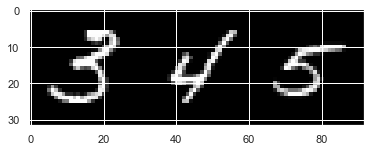

In [64]:
print('La vraie image')
imshow(torchvision.utils.make_grid(to_image(img.detach())[:3]))

L'image corrompue


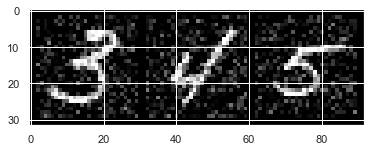

In [65]:
print("L'image corrompue")
imshow(torchvision.utils.make_grid(to_image(noise_img.detach())[:3]))

Après passage AutoEncodeur


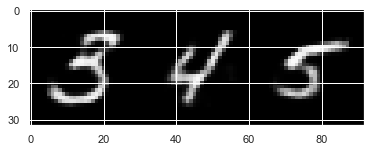

In [66]:
print("Après passage AutoEncodeur")
imshow(torchvision.utils.make_grid(to_image(output.detach())[:3]))

### PCA

In [67]:
from sklearn.decomposition import PCA

In [86]:
from sklearn.datasets import load_digits

In [89]:
data=load_digits().data

True data


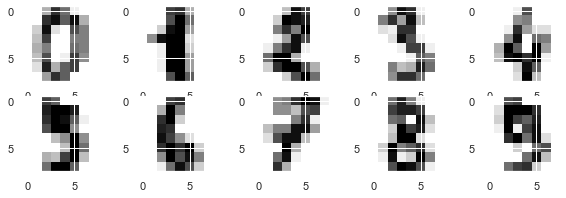

In [176]:

def show_image(data):
    plt.figure(figsize=(10,8))

    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(data[i].reshape(8,8),cmap='binary',clim=(0,16), interpolation='nearest')
        
        
show_image(data)     

print('True data')

In [167]:
def add_noise(img):
    '''
    inputs: image
    _________________________
    
    return: noising image
    
    '''
    noise=np.random.randn(*data.shape)*4
    
    return img+noise



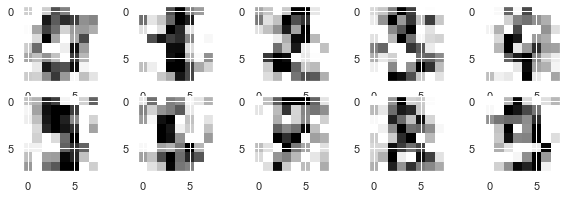

In [168]:
data_noise=add_noise(data)

show_image(data_noise)
print('Corrupted ')

In [173]:
acp=PCA(0.7)

data_acp=acp.fit_transform(data)



In [174]:
data_new=acp.inverse_transform(data_acp)

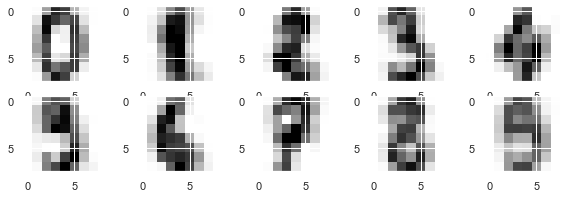

In [175]:
show_image(data_new)